Reference: https://github.com/marload/DeepRL-TensorFlow2/blob/master/DQN/DQN_Discrete.py
https://arxiv.org/pdf/1312.5602.pdf

In [4]:
#!python -m pip install wandb

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import gym
import argparse
import numpy as np
from collections import deque
import random

In [2]:
tf.keras.backend.set_floatx('float64')
#wandb.init(name='DQN', project="deep-rl-tf2")

In [3]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        self.batch_size = 32
    
    def put(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self):
        sample = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(self.batch_size, -1)
        next_states = np.array(next_states).reshape(self.batch_size, -1)
        return states, actions, rewards, next_states, done
    
    def size(self):
        return len(self.buffer)

In [4]:
class ActionStateModel:
    def __init__(self, state_dim, aciton_dim):
        self.state_dim  = state_dim
        self.action_dim = aciton_dim
        self.epsilon = 1.0 #args.eps
        self.lr = 0.005
        self.eps_min = 0.01
        self.eps_decay = 0.995
        
        self.model = self.create_model()
    
    def create_model(self):
        model = tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(self.action_dim)
        ])
        
        model.compile(loss='mse', optimizer=Adam(self.lr))
        return model
    
    def predict(self, state):
        return self.model.predict(state)
    
    def get_action(self, state):
        state = np.reshape(state, [1, self.state_dim])
        self.epsilon *= self.eps_decay
        self.epsilon = max(self.epsilon, self.eps_min)
        q_value = self.predict(state)[0]
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_dim-1)
        return np.argmax(q_value)

    def train(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose=0)


In [9]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

        self.model = ActionStateModel(self.state_dim, self.action_dim)
        self.target_model = ActionStateModel(self.state_dim, self.action_dim)
        self.target_update()
        self.batch_size = 32
        self.gamma = 0.95
        self.rewards = []

        self.buffer = ReplayBuffer()

    def target_update(self):
        weights = self.model.model.get_weights()
        self.target_model.model.set_weights(weights)
    
    def replay(self):
        for _ in range(10):
            states, actions, rewards, next_states, done = self.buffer.sample()
            targets = self.target_model.predict(states)
            #next_q_values = self.target_model.predict(next_states).max(axis=1)
            
            next_q_values = self.target_model.predict(next_states)[range(self.batch_size),
                                                                   np.argmax(self.model.predict(next_states), axis=1)]
            targets[range(self.batch_size), actions] = rewards + (1-done) * next_q_values * self.gamma
            self.model.train(states, targets)
    
    def train(self, max_episodes=1000):
        for ep in range(max_episodes):
            done, total_reward = False, 0
            state = self.env.reset()
            while not done:
                action = self.model.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.buffer.put(state, action, reward*0.01, next_state, done)
                total_reward += reward
                self.rewards.append(total_reward)
                state = next_state
            if self.buffer.size() >= self.batch_size:
                self.replay()
            self.target_update()
            print('EP{} EpisodeReward={}'.format(ep, total_reward))
            #wandb.log({'Reward': total_reward})

```
parser = argparse.ArgumentParser()
parser.add_argument('--gamma', type=float, default=0.95)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--eps', type=float, default=1.0)
parser.add_argument('--eps_decay', type=float, default=0.995)
parser.add_argument('--eps_min', type=float, default=0.01)

args = parser.parse_args()
```

In [10]:
env = gym.make('CartPole-v1')
agent = Agent(env)
agent.train(max_episodes=100)

EP0 EpisodeReward=8.0
EP1 EpisodeReward=15.0
EP2 EpisodeReward=20.0
EP3 EpisodeReward=30.0
EP4 EpisodeReward=15.0
EP5 EpisodeReward=12.0
EP6 EpisodeReward=18.0
EP7 EpisodeReward=10.0
EP8 EpisodeReward=13.0
EP9 EpisodeReward=21.0
EP10 EpisodeReward=14.0
EP11 EpisodeReward=13.0
EP12 EpisodeReward=9.0
EP13 EpisodeReward=13.0
EP14 EpisodeReward=14.0
EP15 EpisodeReward=13.0
EP16 EpisodeReward=18.0
EP17 EpisodeReward=32.0
EP18 EpisodeReward=11.0
EP19 EpisodeReward=27.0
EP20 EpisodeReward=42.0
EP21 EpisodeReward=57.0
EP22 EpisodeReward=38.0
EP23 EpisodeReward=56.0
EP24 EpisodeReward=68.0
EP25 EpisodeReward=111.0
EP26 EpisodeReward=96.0
EP27 EpisodeReward=96.0
EP28 EpisodeReward=100.0
EP29 EpisodeReward=101.0
EP30 EpisodeReward=67.0
EP31 EpisodeReward=25.0
EP32 EpisodeReward=152.0
EP33 EpisodeReward=109.0
EP34 EpisodeReward=92.0
EP35 EpisodeReward=41.0
EP36 EpisodeReward=75.0
EP37 EpisodeReward=164.0
EP38 EpisodeReward=253.0
EP39 EpisodeReward=377.0
EP40 EpisodeReward=131.0
EP41 EpisodeReward=

Text(0, 0.5, 'Reward')

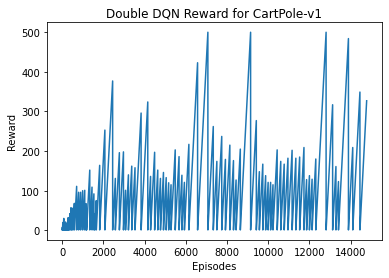

In [21]:
%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt

plt.plot(agent.rewards)
plt.title('Double DQN Reward for CartPole-v1')
plt.xlabel('Episodes')
plt.ylabel('Reward')